# Loading the data

In [29]:
import os

# Define dataset folder path
DATASET_DIR = "/Users/tahfimibnkhan/Desktop/ml_practice/DHAN_DATASET"

# Function to load and pair images (works for multiple folders like BRRI_28 and BRRI_50)
def load_data(dataset_dir):
    dataset = []
    for variety in os.listdir(dataset_dir):
        variety_path = os.path.join(dataset_dir, variety)
        if os.path.isdir(variety_path):  # Ensure it's a directory
            back_images = {}
            front_images = {}

            # Process files in the variety folder
            for img_name in os.listdir(variety_path):
                # Check for back images (_B) and front images (_F)
                if "_B" in img_name:
                    key = img_name.split("_B")[1].split(".")[0]  # Extract the unique ID (e.g., "1" in "BRRI_28_B1.jpeg")
                    back_images[key] = os.path.join(variety_path, img_name)
                elif "_F" in img_name:
                    key = img_name.split("_F")[1].split(".")[0]
                    front_images[key] = os.path.join(variety_path, img_name)

            # Pair back and front images for each key
            for key in back_images:
                if key in front_images:
                    dataset.append({
                        "variety": variety,                  # The folder name (e.g., "BRRI_28" or "BRRI_50")
                        "back_image": back_images[key],      # Path to back image
                        "front_image": front_images[key]     # Path to front image
                    })
    return dataset

# Load dataset
dataset = load_data(DATASET_DIR)
print(f"Loaded {len(dataset)} pairs of rice seed images.")

# Verify varieties
varieties = set(item["variety"] for item in dataset)
print(f"Varieties loaded: {varieties}")


Loaded 22 pairs of rice seed images.
Varieties loaded: {'BRRI_28', 'BRRI_50'}


# Displaying 1 Rice Seed Image from each Variety

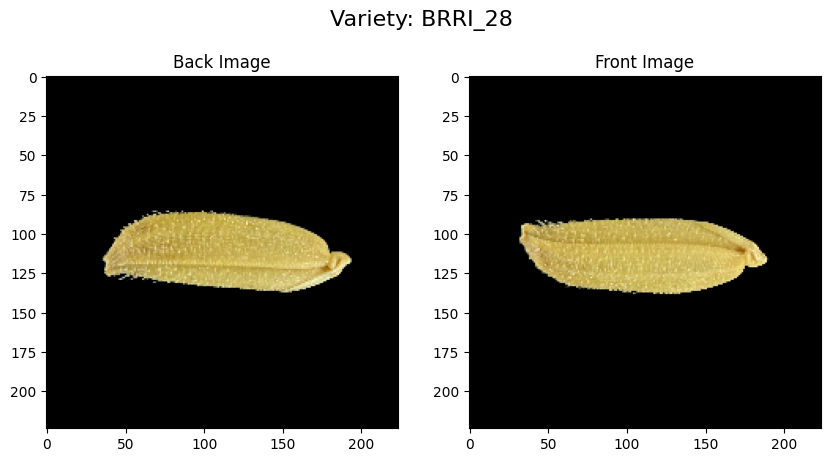

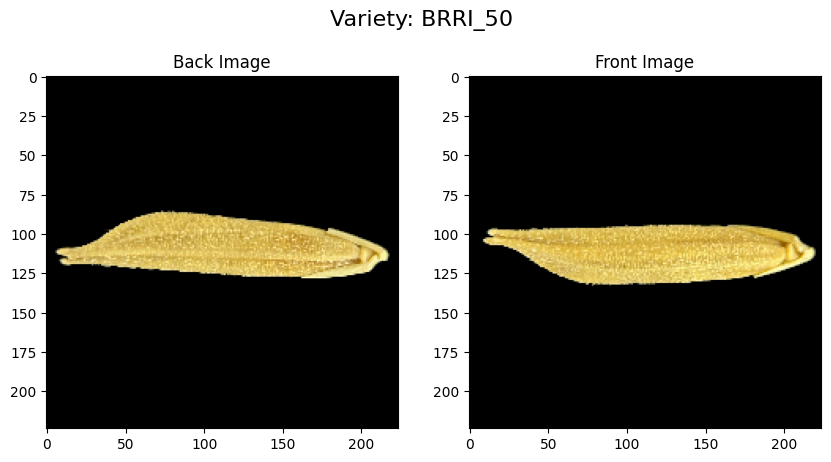

In [31]:
import cv2
import matplotlib.pyplot as plt

# Display one rice seed from each variety
for variety in varieties:
    for item in dataset:
        if item["variety"] == variety:
            back_image = cv2.imread(item["back_image"])
            front_image = cv2.imread(item["front_image"])

            # Resize images for display
            back_resized = cv2.resize(back_image, (224, 224))
            front_resized = cv2.resize(front_image, (224, 224))

            # Display images
            plt.figure(figsize=(10, 5))
            plt.suptitle(f"Variety: {variety}", fontsize=16)

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(back_resized, cv2.COLOR_BGR2RGB))
            plt.title("Back Image")

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(front_resized, cv2.COLOR_BGR2RGB))
            plt.title("Front Image")

            plt.show()

            break  # Break to only display one pair per variety


# Applying augmentation to increase dataset and Addd Variety

In [37]:
import albumentations as A
import cv2
import os
from tqdm import tqdm

# Augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),                 # Flip horizontally
    A.Rotate(limit=45, p=0.5),              # Rotate image by ±45 degrees
    A.RandomScale(scale_limit=0.2, p=0.5),  # Scale image by ±20%
    A.RandomBrightnessContrast(p=0.5),      # Adjust brightness and contrast
    A.ColorJitter(p=0.5)                    # Apply color jittering
])

# Directory to save augmented images
AUGMENTED_DIR = "/Users/tahfimibnkhan/Desktop/ml_practice/DHAN_DATASET_AUGMENTED"
os.makedirs(AUGMENTED_DIR, exist_ok=True)

# Function to apply augmentation and save multiple augmented images
def augment_and_save(data, output_dir, num_augmentations=5):
    """
    Augment the dataset to increase its size.
    
    Args:
    - data (list): The original dataset (list of dicts containing image paths).
    - output_dir (str): Directory to save the augmented dataset.
    - num_augmentations (int): Number of augmented images to generate per original image.

    Returns:
    - augmented_dataset (list): List containing paths to augmented images.
    """
    augmented_dataset = []

    for item in tqdm(data, desc="Augmenting Images"):
        for part in ['back_image', 'front_image']:
            img_path = item[part]
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # Resize for uniformity

            for i in range(num_augmentations):
                # Apply augmentations
                augmented = augmentations(image=img)
                augmented_img = augmented['image']

                # Save augmented image
                variety = item['variety']
                output_folder = os.path.join(output_dir, variety)
                os.makedirs(output_folder, exist_ok=True)

                # Create a unique filename for each augmentation
                img_name = os.path.basename(img_path).replace(".jpeg", f"_aug{i+1}.jpeg")
                augmented_img_path = os.path.join(output_folder, img_name)
                cv2.imwrite(augmented_img_path, augmented_img)

                # Add augmented image info to the dataset
                augmented_dataset.append({
                    "variety": variety,
                    "image_type": "back" if part == "back_image" else "front",
                    "image_path": augmented_img_path,
                    "original_path": img_path
                })

    print(f"Augmented images saved to {output_dir}")
    return augmented_dataset

# Apply augmentation and save augmented dataset
NUM_AUGMENTATIONS = 5  # Number of augmented images per original image
augmented_data = augment_and_save(dataset, AUGMENTED_DIR, num_augmentations=NUM_AUGMENTATIONS)

print(f"Total augmented images: {len(augmented_data)}")


Augmenting Images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.29it/s]

Augmented images saved to /Users/tahfimibnkhan/Desktop/ml_practice/DHAN_DATASET_AUGMENTED
Total augmented images: 220


# Deep Feature Extraction
### 1. Extracted deep features of orginal image dataset and augmented image dataset using a pre-trained CNN (ResNet50) from TensorFlow.
### 2. Stored the extracted deep features in a CSV file (deep_features.csv), where each row corresponds to a seed.

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet50 model for feature extraction
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Ensure uniform size
    img = preprocess_input(img)  # Preprocess for ResNet50
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    features = model.predict(img)  # Extract features
    return features.flatten()  # Flatten to 1D vector

# Extract features for a dataset
def extract_features_for_dataset(data):
    feature_list = []
    for item in tqdm(data, desc="Extracting Features"):
        # Get image paths
        if "back_image" in item and "front_image" in item:  # For original data
            back_image_path = item["back_image"]
            front_image_path = item["front_image"]
        elif "image_type" in item:  # For augmented data
            back_image_path = item["image_path"] if item["image_type"] == "back" else None
            front_image_path = item["image_path"] if item["image_type"] == "front" else None
        else:
            continue

        # Extract features for back and front images
        if back_image_path and front_image_path:
            back_features = extract_features(back_image_path)
            front_features = extract_features(front_image_path)
            combined_features = np.concatenate([back_features, front_features])  # Combine features

            # Store features
            feature_list.append({
                "variety": item["variety"],
                "features": combined_features
            })
    return feature_list

# Extract features for original and augmented datasets
original_features = extract_features_for_dataset(dataset)
augmented_features = extract_features_for_dataset(augmented_data)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step 


2025-01-14 06:02:04.589045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.                           | 0/22 [00:00<?, ?it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:   5%|██████▋                                                                                                                                            | 1/22 [00:04<01:32,  4.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting Features:   9%|█████████████▎                                                                                                                                     | 2/22 [00:04<00:38,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  14%|████████████████████                                                                                                                               | 3/22 [00:04<00:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting Features:  18%|██████████████████████████▋                                                                                                                        | 4/22 [00:04<00:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting Features:  23%|█████████████████████████████████▍                                                                                                                 | 5/22 [00:05<00:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting Features:  27%|████████████████████████████████████████                                                                                                           | 6/22 [00:05<00:06,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features:  32%|██████████████████████████████████████████████▊                                                                                                    | 7/22 [00:05<00:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting Features:  36%|█████████████████████████████████████████████████████▍                                                                                             | 8/22 [00:05<00:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting Features:  41%|████████████████████████████████████████████████████████████▏                                                                                      | 9/22 [00:05<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  45%|██████████████████████████████████████████████████████████████████▎                                                                               | 10/22 [00:05<00:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting Features:  50%|█████████████████████████████████████████████████████████████████████████                                                                         | 11/22 [00:06<00:02,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting Features:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 12/22 [00:06<00:01,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting Features:  59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 13/22 [00:06<00:01,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting Features:  64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 14/22 [00:06<00:01,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 15/22 [00:06<00:01,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting Features:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 16/22 [00:06<00:01,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting Features:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 17/22 [00:07<00:00,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 18/22 [00:07<00:00,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting Features:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19/22 [00:07<00:00,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting Features:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 20/22 [00:07<00:00,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 21/22 [00:07<00:00,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1630294.84it/s]


## Saving the deep features

In [39]:
import pandas as pd

# Save features to CSV
def save_features_to_csv(features, filename):
    rows = []
    for item in features:
        row = {"variety": item["variety"]}
        row.update({f"feature_{i}": value for i, value in enumerate(item["features"])})
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Features saved to {filename}")

# Save features for original and augmented datasets
save_features_to_csv(original_features, "original_features.csv")
save_features_to_csv(augmented_features, "augmented_features.csv")


Features saved to original_features.csv
Features saved to augmented_features.csv


## Display a sample of extracted features from the original dataset

In [40]:
# Display a sample of extracted features from the original dataset
for i, item in enumerate(original_features[:5]):  # Display the first 5 samples
    print(f"Sample {i + 1}:")
    print(f"Variety: {item['variety']}")
    print(f"Features (length = {len(item['features'])}): {item['features'][:10]}...")  # Show only the first 10 features for brevity
    print("-" * 50)


Sample 1:
Variety: BRRI_50
Features (length = 4096): [3.2934031e+00 0.0000000e+00 5.0176072e-01 1.7493841e-03 2.4883151e-01
 8.7527484e-02 2.0136486e-01 0.0000000e+00 6.8052426e-02 0.0000000e+00]...
--------------------------------------------------
Sample 2:
Variety: BRRI_50
Features (length = 4096): [1.7358146  0.5386271  0.3605992  0.02029083 0.23176081 0.33555037
 0.31082195 0.         0.05998072 0.03223773]...
--------------------------------------------------
Sample 3:
Variety: BRRI_50
Features (length = 4096): [2.4892628  0.10760794 0.16082053 0.         0.08914823 0.00841929
 0.5343616  0.         0.08844201 0.00283026]...
--------------------------------------------------
Sample 4:
Variety: BRRI_50
Features (length = 4096): [2.5179152  0.05029197 0.0859485  0.         0.02821418 0.9640752
 0.24811837 0.         0.04086057 0.        ]...
--------------------------------------------------
Sample 5:
Variety: BRRI_50
Features (length = 4096): [1.7200528  0.16314913 0.04892807 0.01

In [41]:
import pandas as pd

# Load the original feature CSV
original_features_df = pd.read_csv("original_features.csv")

# Display the first 5 rows of the CSV
print("Original Features (First 5 Rows):")
print(original_features_df.head())

# Display details about the dataset
print("\nColumn Names (Features + Variety):")
print(original_features_df.columns[:10])  # Display first 10 column names
print(f"\nTotal Number of Features: {len(original_features_df.columns) - 1}")  # Subtract 'variety' column


Original Features (First 5 Rows):
   variety  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  BRRI_50   3.293403   0.000000   0.501761   0.001749   0.248832   0.087527   
1  BRRI_50   1.735815   0.538627   0.360599   0.020291   0.231761   0.335550   
2  BRRI_50   2.489263   0.107608   0.160821   0.000000   0.089148   0.008419   
3  BRRI_50   2.517915   0.050292   0.085949   0.000000   0.028214   0.964075   
4  BRRI_50   1.720053   0.163149   0.048928   0.016428   0.154677   0.209690   

   feature_6  feature_7  feature_8  ...  feature_4086  feature_4087  \
0   0.201365   0.000000   0.068052  ...      0.132675      0.178043   
1   0.310822   0.000000   0.059981  ...      0.208341      0.223707   
2   0.534362   0.000000   0.088442  ...      0.131858      0.358754   
3   0.248118   0.000000   0.040861  ...      0.054411      0.372473   
4   0.629863   0.006024   0.070731  ...      0.125775      0.079493   

   feature_4088  feature_4089  feature_4090  feature_4091 

# Handcrafted Feature Extraction

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Step 1: Load and Pair Images
DATASET_DIR = "/Users/tahfimibnkhan/Desktop/ml_practice/DHAN_DATASET"

def load_data(dataset_dir):
    dataset = []
    for variety in os.listdir(dataset_dir):
        variety_path = os.path.join(dataset_dir, variety)
        if os.path.isdir(variety_path):  # Ensure it's a directory
            back_images = {}
            front_images = {}

            # Process files in the variety folder
            for img_name in os.listdir(variety_path):
                if "_B" in img_name:
                    key = img_name.split("_B")[1].split(".")[0]
                    back_images[key] = os.path.join(variety_path, img_name)
                elif "_F" in img_name:
                    key = img_name.split("_F")[1].split(".")[0]
                    front_images[key] = os.path.join(variety_path, img_name)

            # Pair back and front images for each key
            for key in back_images:
                if key in front_images:
                    dataset.append({
                        "variety": variety,
                        "back_image": back_images[key],
                        "front_image": front_images[key]
                    })
    return dataset

dataset = load_data(DATASET_DIR)
print(f"Loaded {len(dataset)} pairs of rice seed images.")
print(f"Varieties loaded: {set(item['variety'] for item in dataset)}")

# Step 2: Define Feature Extraction Functions
def extract_color_features(image):
    mean_rgb = np.mean(image, axis=(0, 1))
    std_rgb = np.std(image, axis=(0, 1))
    median_rgb = np.median(image, axis=(0, 1))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_gray = np.mean(gray)
    std_gray = np.std(gray)
    return np.concatenate([mean_rgb, std_rgb, median_rgb, [mean_gray, std_gray]])

def extract_lbp_features(image, num_points=8, radius=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = np.zeros_like(gray)
    for i in range(radius, gray.shape[0] - radius):
        for j in range(radius, gray.shape[1] - radius):
            center_pixel = gray[i, j]
            binary = ''
            for dy, dx in [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]:
                neighbor_pixel = gray[i + dy, j + dx]
                binary += '1' if neighbor_pixel > center_pixel else '0'
            lbp[i, j] = int(binary, 2)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 1), range=(0, num_points))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)
    return lbp_hist

def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return [0, 0, 0, 0]
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h > 0 else 0
    extent = area / (w * h) if w * h > 0 else 0
    return [area, perimeter, aspect_ratio, extent]

def extract_handcrafted_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    color_features = extract_color_features(image)
    lbp_features = extract_lbp_features(image)
    shape_features = extract_shape_features(image)
    return np.concatenate([color_features, lbp_features, shape_features])

def process_dataset_for_handcrafted_features(dataset):
    feature_list = []
    for item in tqdm(dataset, desc="Extracting Handcrafted Features"):
        back_features = extract_handcrafted_features(item["back_image"])
        front_features = extract_handcrafted_features(item["front_image"])
        combined_features = np.concatenate([back_features, front_features])
        feature_list.append({
            "variety": item["variety"],
            "features": combined_features
        })
    return feature_list

# Step 3: Extract Features and Save to CSV
def save_handcrafted_features_to_csv(features, filename):
    rows = []
    for item in features:
        row = {"variety": item["variety"]}
        row.update({f"feature_{i}": value for i, value in enumerate(item["features"])})
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Handcrafted features saved to {filename}")

handcrafted_features = process_dataset_for_handcrafted_features(dataset)
save_handcrafted_features_to_csv(handcrafted_features, "handcrafted_features_no_skimage.csv")


Loaded 22 pairs of rice seed images.
Varieties loaded: {'BRRI_50', 'BRRI_28'}


Extracting Handcrafted Features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.86it/s]

Handcrafted features saved to handcrafted_features_no_skimage.csv


# Extracted Features and Added descriptive feature names

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from tqdm import tqdm

# Dataset directory
DATASET_DIR = "/Users/tahfimibnkhan/Desktop/ml_practice/DHAN_DATASET"

# Function to load and pair back and front images
def load_data(dataset_dir):
    dataset = []
    for variety in os.listdir(dataset_dir):
        variety_path = os.path.join(dataset_dir, variety)
        if os.path.isdir(variety_path):  # Ensure it's a directory
            back_images = {}
            front_images = {}

            # Identify back (_B) and front (_F) images
            for img_name in os.listdir(variety_path):
                if "_B" in img_name:
                    key = img_name.split("_B")[1].split(".")[0]  # Extract unique ID
                    back_images[key] = os.path.join(variety_path, img_name)
                elif "_F" in img_name:
                    key = img_name.split("_F")[1].split(".")[0]
                    front_images[key] = os.path.join(variety_path, img_name)

            # Pair back and front images
            for key in back_images:
                if key in front_images:
                    dataset.append({
                        "variety": variety,
                        "back_image": back_images[key],
                        "front_image": front_images[key]
                    })
    return dataset

# Load the dataset
dataset = load_data(DATASET_DIR)
print(f"Loaded {len(dataset)} pairs of rice seed images.")


Loaded 22 pairs of rice seed images.


In [8]:
# Extract Shape Features
def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return [0, 0, 0, 0, 0, 0]  # No contours found

    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h > 0 else 0
    convex_area = cv2.contourArea(cv2.convexHull(largest_contour))
    extent = area / (w * h) if w * h > 0 else 0
    solidity = area / convex_area if convex_area > 0 else 0
    return [area, perimeter, aspect_ratio, convex_area, extent, solidity]

# Extract Color Features
def extract_color_features(image):
    mean_colors = np.mean(image, axis=(0, 1))  # Mean R, G, B
    std_colors = np.std(image, axis=(0, 1))    # Std R, G, B
    skew_colors = skew(image.reshape(-1, 3), axis=0)  # Skewness R, G, B
    kurt_colors = kurtosis(image.reshape(-1, 3), axis=0)  # Kurtosis R, G, B
    return list(mean_colors) + list(std_colors) + list(skew_colors) + list(kurt_colors)

# Combine Features
def extract_features(image_path):
    # Load and resize image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize to uniform size

    # Extract features
    shape_features = extract_shape_features(image)
    color_features = extract_color_features(image)

    # Combine shape and color features
    return shape_features + color_features


In [9]:
def process_dataset(dataset):
    feature_list = []

    for item in tqdm(dataset, desc="Extracting Features"):
        # Extract features for back and front images
        back_features = extract_features(item["back_image"])
        front_features = extract_features(item["front_image"])

        # Combine back and front features
        combined_features = back_features + front_features

        # Append features with variety label
        feature_list.append({
            "variety": item["variety"],
            "features": combined_features
        })
    
    return feature_list


In [10]:
# Generate feature names
def get_feature_names():
    shape_features = ["area", "perimeter", "aspect_ratio", "convex_area", "extent", "solidity"]
    color_features = [
        "mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B",
        "skew_R", "skew_G", "skew_B", "kurtosis_R", "kurtosis_G", "kurtosis_B"
    ]

    # Feature names for back and front
    back_feature_names = [f"back_{name}" for name in shape_features + color_features]
    front_feature_names = [f"front_{name}" for name in shape_features + color_features]

    return back_feature_names + front_feature_names

# Save features to CSV
def save_features_to_csv(features, filename):
    feature_names = get_feature_names()
    rows = []

    for item in features:
        row = {"variety": item["variety"]}
        row.update({feature_name: value for feature_name, value in zip(feature_names, item["features"])})
        rows.append(row)

    # Save to CSV
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Features saved to {filename}")


In [11]:
# Process the dataset
extracted_features = process_dataset(dataset)

# Save to CSV
save_features_to_csv(extracted_features, "rice_seed_features.csv")


Extracting Features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 15.08it/s]


Features saved to rice_seed_features.csv


# Analyzing Handcrafted Features

### Loading Handcrafted Features

In [14]:
import pandas as pd

# Load the handcrafted features CSV file
handcrafted_features_path = "/Users/tahfimibnkhan/Desktop/ml_practice/handcrafted_features.csv"
handcrafted_df = pd.read_csv(handcrafted_features_path)

# Display the first few rows
print("Handcrafted Features (First 5 Rows):")
print(handcrafted_df.head())

# Check the column names (features)
print("\nFeature Names:")
print(handcrafted_df.columns)


Handcrafted Features (First 5 Rows):
   variety  back_area  back_perimeter  back_aspect_ratio  back_convex_area  \
0  BRRI_50     5766.5      476.350286           4.883721            6166.5   
1  BRRI_50     5961.5      485.462984           5.121951            6499.5   
2  BRRI_50     5590.0      452.936073           5.128205            6001.0   
3  BRRI_50     5198.0      430.592926           4.897436            5763.5   
4  BRRI_50     5831.0      456.936072           5.125000            6293.5   

   back_extent  back_solidity  back_mean_R  back_mean_G  back_mean_B  ...  \
0     0.638594       0.935133    11.963190    23.176060    26.566805  ...   
1     0.692393       0.917224    11.576969    23.544762    27.103795  ...   
2     0.716667       0.931511     9.693080    21.480947    25.562899  ...   
3     0.697812       0.901883    10.829281    20.809730    23.934311  ...   
4     0.711098       0.926511    11.159598    23.251176    26.701112  ...   

   front_mean_B  front_std_R  f

# Visualizing Feature Distributions

## Histogram of a Single Feature

In [16]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


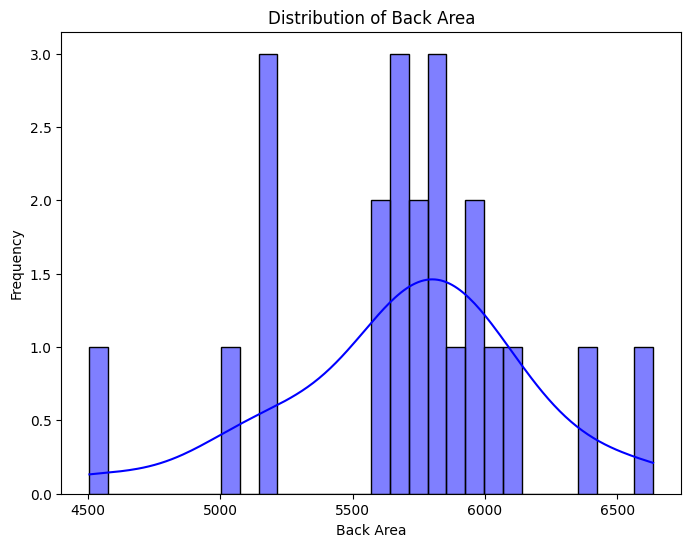

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of the back_area feature
plt.figure(figsize=(8, 6))
sns.histplot(handcrafted_df['back_area'], kde=True, bins=30, color='blue')
plt.title("Distribution of Back Area")
plt.xlabel("Back Area")
plt.ylabel("Frequency")
plt.show()


## Boxplot of Features by Variety

/var/folders/mk/5l02p9bd68z1bcn783n8hzd00000gn/T/ipykernel_54769/1814699980.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variety', y='back_area', data=handcrafted_df, palette="Set3")


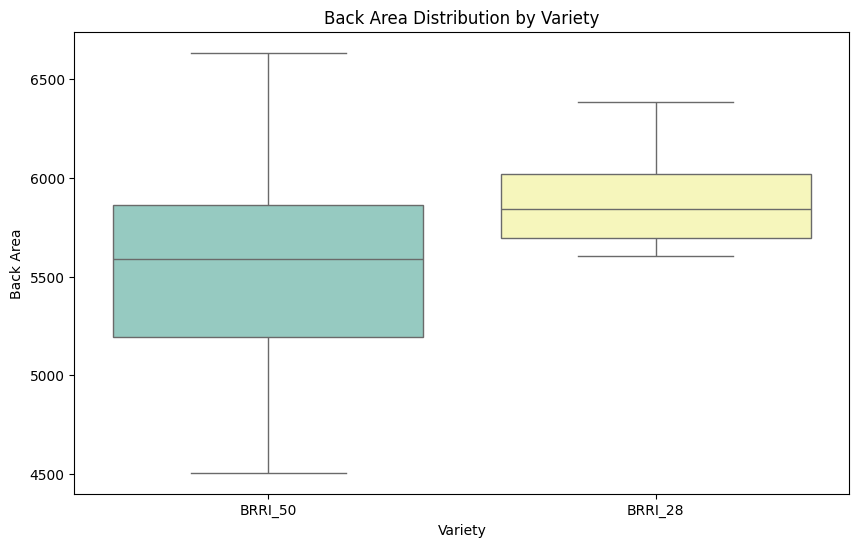

In [18]:
# Plot boxplot of back_area grouped by variety
plt.figure(figsize=(10, 6))
sns.boxplot(x='variety', y='back_area', data=handcrafted_df, palette="Set3")
plt.title("Back Area Distribution by Variety")
plt.xlabel("Variety")
plt.ylabel("Back Area")
plt.show()


## Summary Statistics

In [19]:
# Summary statistics for numerical features
print("Summary Statistics:")
print(handcrafted_df.describe())

Summary Statistics:
         back_area  back_perimeter  back_aspect_ratio  back_convex_area  \
count    22.000000       22.000000          22.000000         22.000000   
mean   5700.613636      425.314712           4.085995       6068.409091   
std     462.832633       33.569770           0.694049        492.039358   
min    4506.500000      379.906635           3.038462       4846.500000   
25%    5594.000000      401.488110           3.487457       5853.750000   
50%    5744.500000      419.391916           3.843276       6080.500000   
75%    5945.500000      450.749781           4.757156       6322.375000   
max    6635.000000      485.462984           5.128205       6983.000000   

       back_extent  back_solidity  back_mean_R  back_mean_G  back_mean_B  \
count    22.000000      22.000000    22.000000    22.000000    22.000000   
mean      0.709158       0.939613    11.011712    21.846869    24.845187   
std       0.039064       0.021933     0.918391     1.555763     1.845658   


## Correlation Heatmap

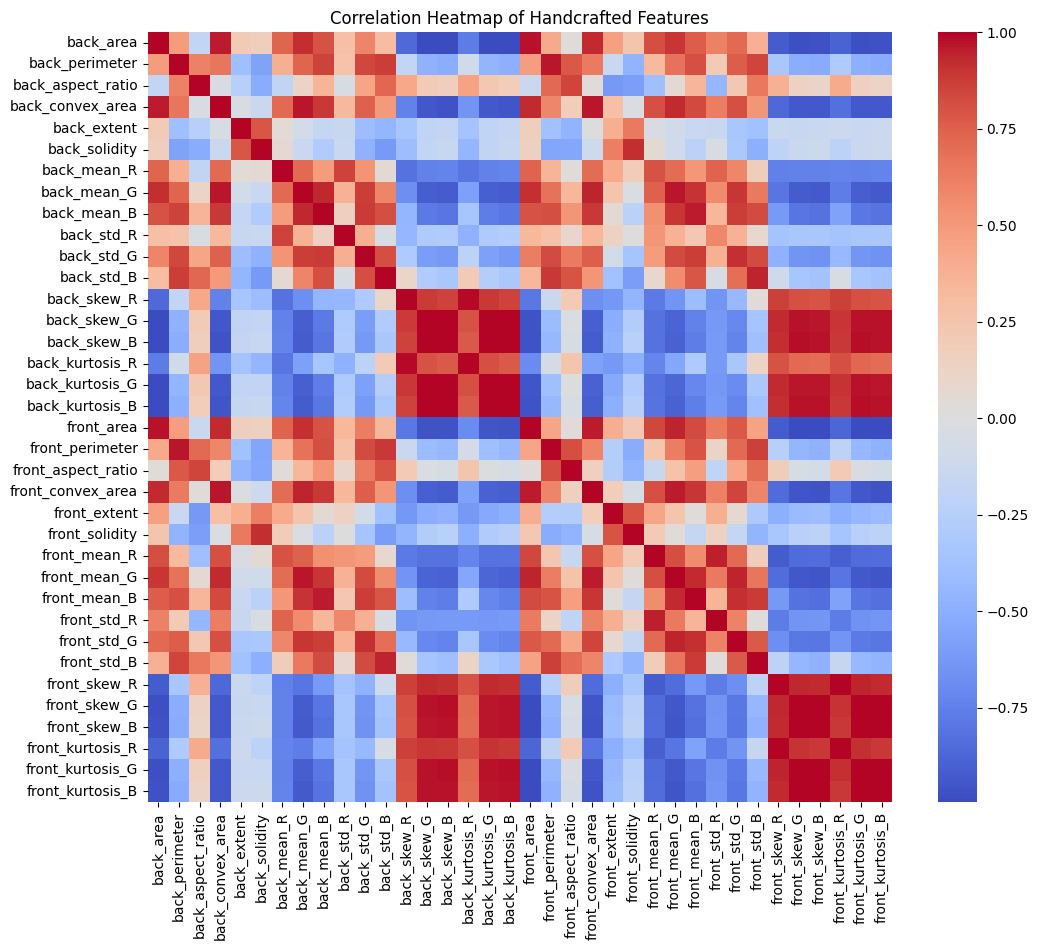

In [20]:
# Compute correlation matrix (exclude the 'variety' column)
correlation_matrix = handcrafted_df.drop(columns=['variety']).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Handcrafted Features")
plt.show()


## Dimensionality Reduction (PCA)
### **Reduced the 36 handcrafted features (18 back + 18 front) to 2 dimensions using PCA and plot the results**

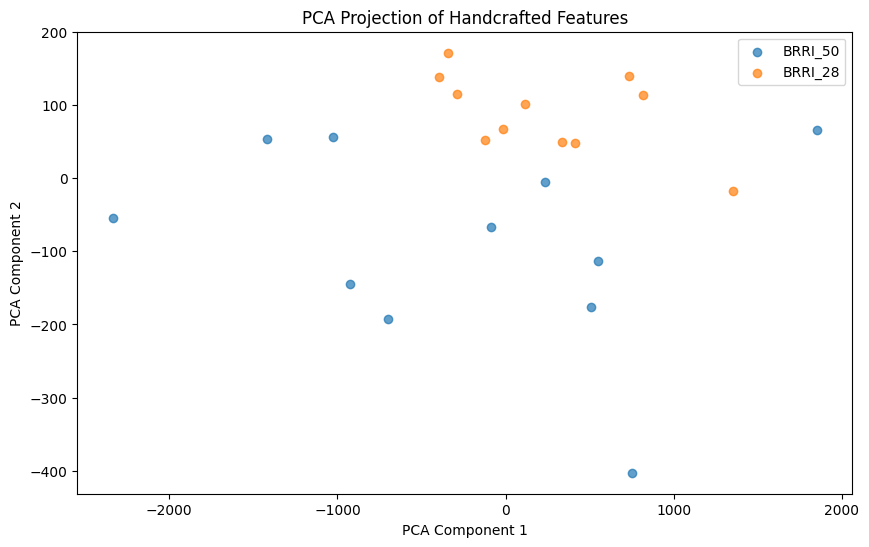

In [21]:
from sklearn.decomposition import PCA

# Prepare features and labels
X_handcrafted = handcrafted_df.drop(columns=['variety']).values
y_handcrafted = handcrafted_df['variety']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_handcrafted)

# Create a scatter plot of the PCA result
plt.figure(figsize=(10, 6))
for label in y_handcrafted.unique():
    plt.scatter(X_pca[y_handcrafted == label, 0], 
                X_pca[y_handcrafted == label, 1], 
                label=label, alpha=0.7)
plt.title("PCA Projection of Handcrafted Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


## Dimensionality Reduction (t-SNE)
### ->t-SNE to visualize the feature space in 2 dimensions

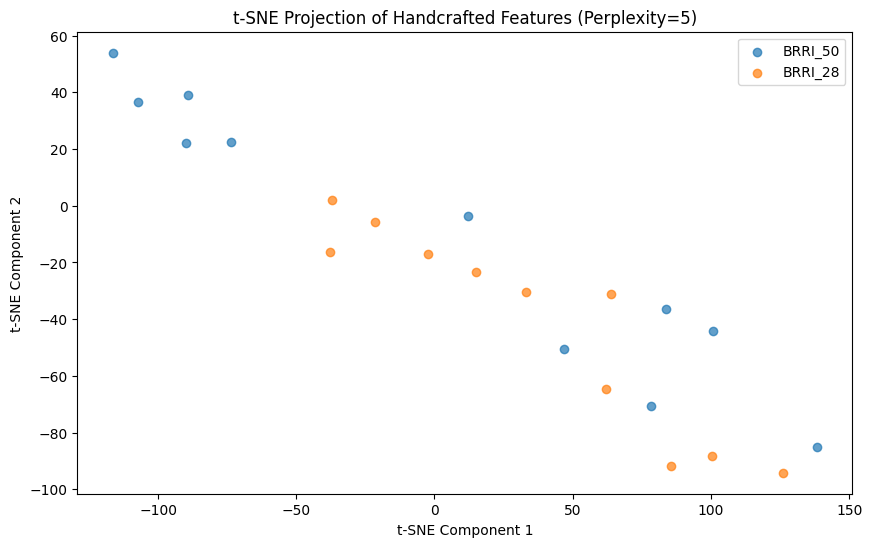

In [24]:
from sklearn.manifold import TSNE

# Ensure perplexity is smaller than the number of samples
n_samples = X_handcrafted.shape[0]
perplexity_value = min(5, n_samples // 2)  # Use a smaller perplexity for small datasets

# Perform t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
X_tsne = tsne.fit_transform(X_handcrafted)

# Create a scatter plot of the t-SNE result
plt.figure(figsize=(10, 6))
for label in y_handcrafted.unique():
    plt.scatter(
        X_tsne[y_handcrafted == label, 0], 
        X_tsne[y_handcrafted == label, 1], 
        label=label, alpha=0.7
    )
plt.title(f"t-SNE Projection of Handcrafted Features (Perplexity={perplexity_value})")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


# Analyzing Deep Features

In [26]:
# Load the deep features CSV file
deep_features_path = "/Users/tahfimibnkhan/Desktop/ml_practice/original_features.csv"
deep_df = pd.read_csv(deep_features_path)

# Display the first few rows
print("Deep Features (First 5 Rows):")
print(deep_df.head())

Deep Features (First 5 Rows):
   variety  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  BRRI_50   3.293403   0.000000   0.501761   0.001749   0.248832   0.087527   
1  BRRI_50   1.735815   0.538627   0.360599   0.020291   0.231761   0.335550   
2  BRRI_50   2.489263   0.107608   0.160821   0.000000   0.089148   0.008419   
3  BRRI_50   2.517915   0.050292   0.085949   0.000000   0.028214   0.964075   
4  BRRI_50   1.720053   0.163149   0.048928   0.016428   0.154677   0.209690   

   feature_6  feature_7  feature_8  ...  feature_4086  feature_4087  \
0   0.201365   0.000000   0.068052  ...      0.132675      0.178043   
1   0.310822   0.000000   0.059981  ...      0.208341      0.223707   
2   0.534362   0.000000   0.088442  ...      0.131858      0.358754   
3   0.248118   0.000000   0.040861  ...      0.054411      0.372473   
4   0.629863   0.006024   0.070731  ...      0.125775      0.079493   

   feature_4088  feature_4089  feature_4090  feature_4091  fea

## Dimensionality Reduction (PCA)

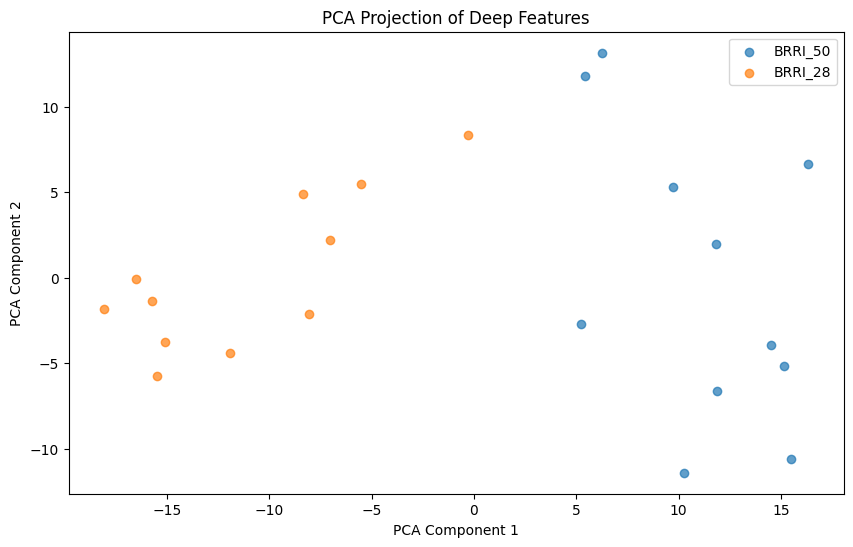

In [27]:
# Prepare features and labels
X_deep = deep_df.drop(columns=['variety']).values
y_deep = deep_df['variety']

# Perform PCA
pca = PCA(n_components=2)
X_pca_deep = pca.fit_transform(X_deep)

# Create a scatter plot
plt.figure(figsize=(10, 6))
for label in y_deep.unique():
    plt.scatter(X_pca_deep[y_deep == label, 0], 
                X_pca_deep[y_deep == label, 1], 
                label=label, alpha=0.7)
plt.title("PCA Projection of Deep Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


## Dimensionality Reduction (t-SNE)

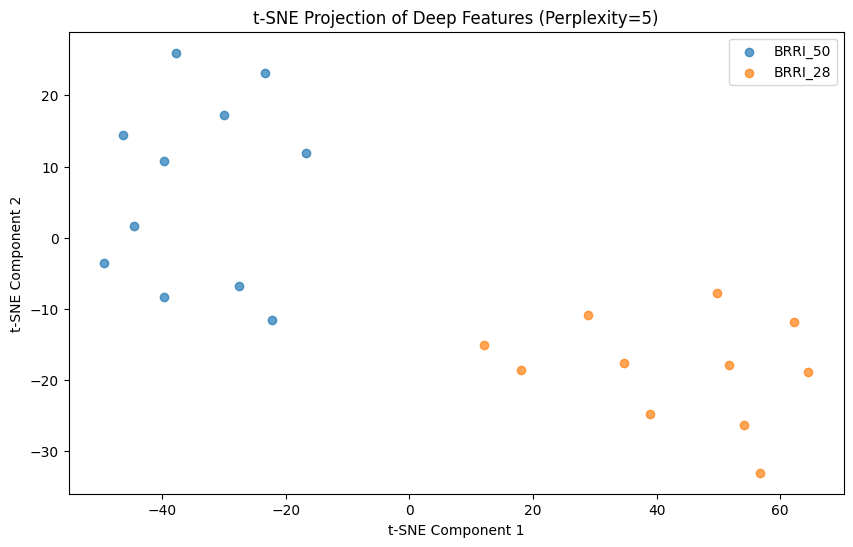

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE with adjusted perplexity
perplexity = min(5, len(X_deep) - 1)  # Set a small perplexity, e.g., 5, or slightly less than the number of samples
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X_tsne_deep = tsne.fit_transform(X_deep)

# Create a scatter plot of the t-SNE result
plt.figure(figsize=(10, 6))
for label in y_deep.unique():
    plt.scatter(X_tsne_deep[y_deep == label, 0], 
                X_tsne_deep[y_deep == label, 1], 
                label=label, alpha=0.7)
plt.title(f"t-SNE Projection of Deep Features (Perplexity={perplexity})")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()